В этом ноутбуке описаны эксперименты с SSA и TSSA, сравнивающие их результаты при реконструкции временных рядов. За данные взято потребление электричества за 2015-2016 год

---

Experiment parametrs

In [1]:
dataset_name = 'energy_consumption.xls'
ssa_window_width = 24 * 7

hankelization_window_width = 24
parafac_rank = 24

---

In [2]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

from os import listdir, getcwd, chdir, makedirs
from os.path import isfile, join
import os

import IPython.display as display

from time import time

sns.set_style("darkgrid")

In [3]:
import tensorly as tl
import pyts.decomposition as pytsd

In [4]:
data = pd.read_excel(f'data/{dataset_name}')
data.head()

,Date,WeekDay,Hour,ConsumprionMWtH,TemperatureC
0,2005-01-01 00:00:00,6,00:00:00,1289.617859,-10.676569
1,2005-01-01 01:00:00,6,01:00:00,1265.573853,-12.041959
2,2005-01-01 02:00:00,6,02:00:00,1273.188232,-13.198006
3,2005-01-01 03:00:00,6,03:00:00,1279.703979,-13.999279
4,2005-01-01 04:00:00,6,04:00:00,1292.839539,-14.782819


График потребления электричества за год

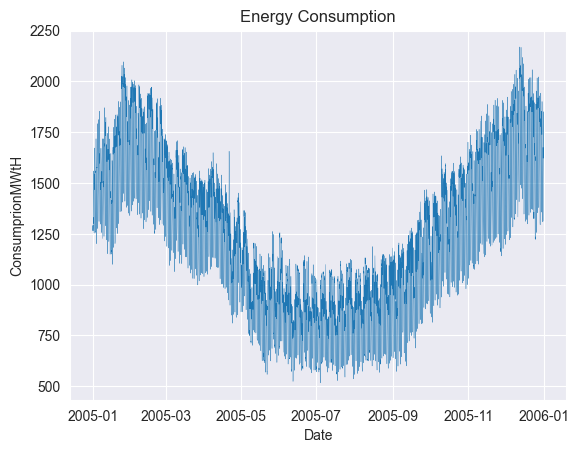

In [5]:
sns.lineplot(data, x='Date', y='ConsumprionMWtH', linewidth=0.25)
plt.title('Energy Consumption')
plt.show()

Месяц потребления по неделям

In [6]:
def take_week(data, week_idx):
    idx_from = 24 * 7 * (week_idx - 1)
    idx_to = 24 * 7 * week_idx
    return data[idx_from:idx_to]

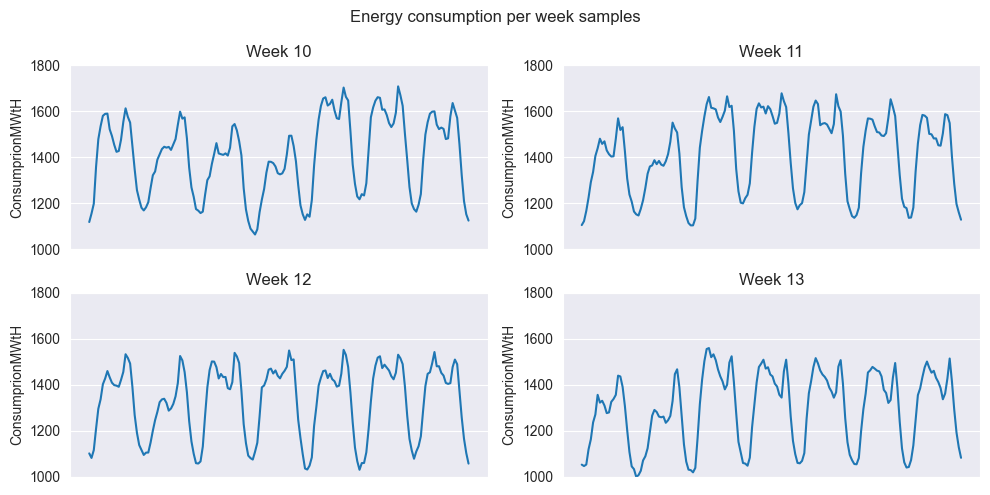

In [41]:
# plot one week

fig = plt.figure(figsize=(10, 5))

for week in range(10, 14):
    data_week = take_week(data, week)

    plt.subplot(2, 2, week - 9)

    sns.lineplot(data_week, x=np.arange(0, 24 * 7), y='ConsumprionMWtH')
    plt.ylim(1000, 1800)
    plt.xticks([])
    plt.title(f'Week {week}')

fig.suptitle('Energy consumption per week samples')

plt.tight_layout()
plt.show()

In [8]:
t = data['Date'].values
x = data['ConsumprionMWtH'].values

In [18]:
window_width = 24

ssa = pytsd.SingularSpectrumAnalysis(window_size=window_width)
ssa_x = ssa.fit_transform(x.reshape(1, -1))

Сумма до первых 10 компонент за год

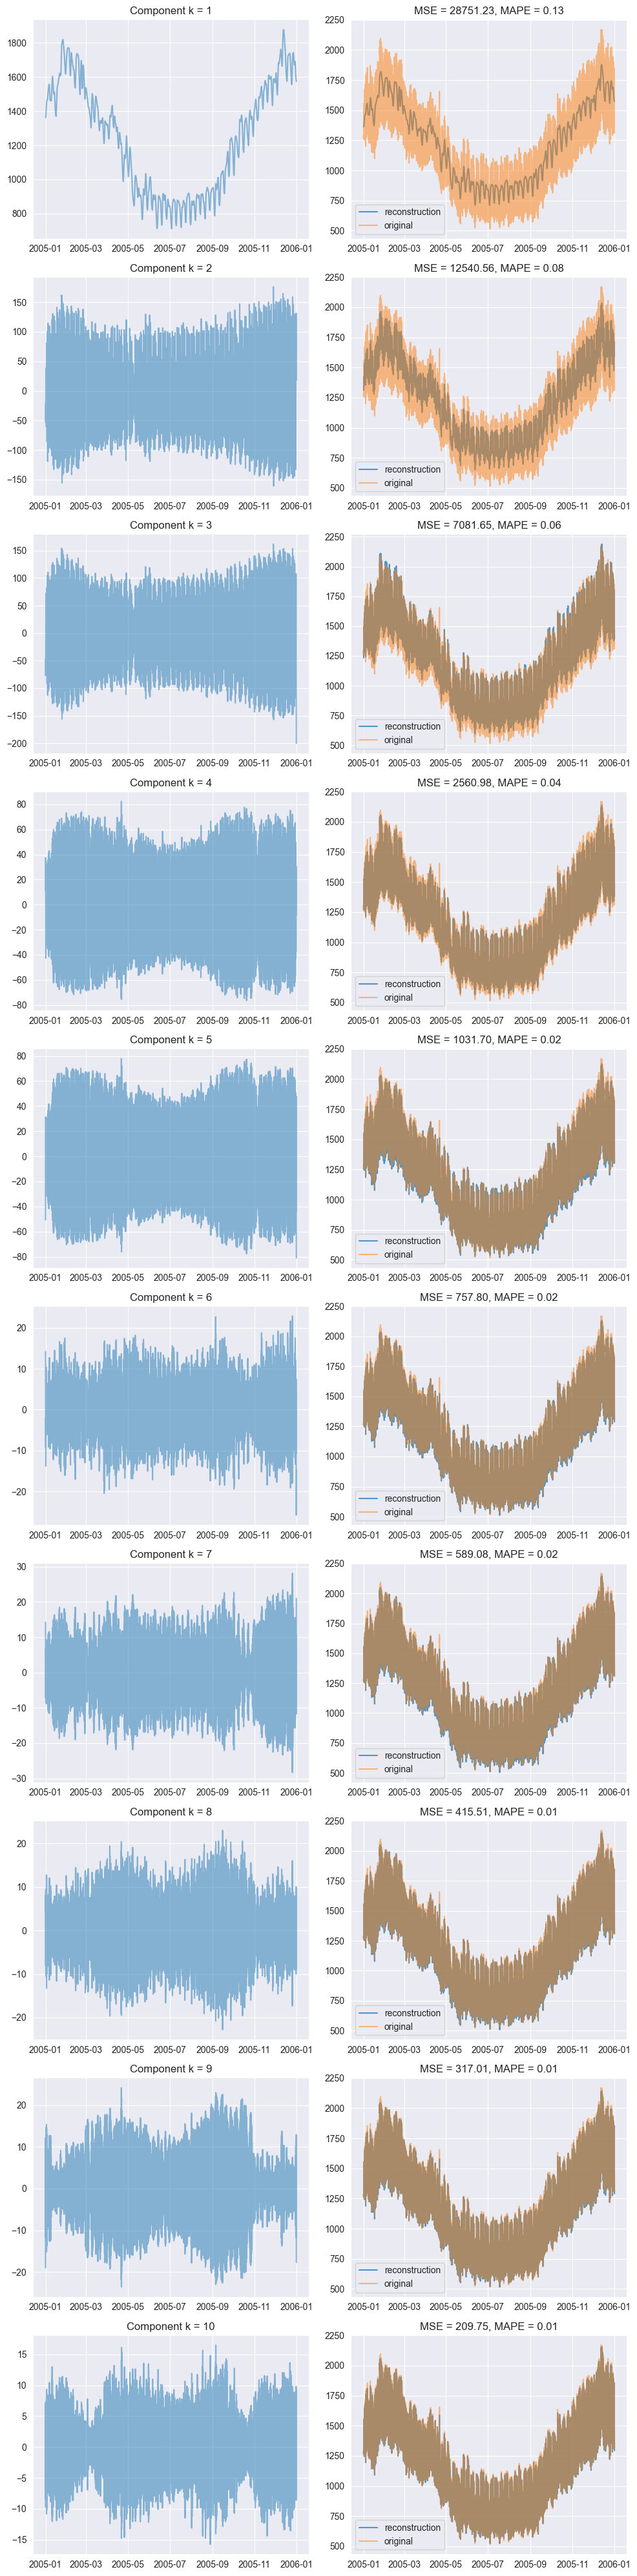

In [19]:
window_take = 10

metrics = {
    'MSE': [],
    'MAPE': []
}

fig = plt.figure(figsize=(10, window_take * 4))
for k in range(0, window_take):
    plt.subplot(window_take, 2, 2 * k + 1)

    kth_component = ssa_x[k]
    plt.plot(t, kth_component, label=f'k = {k+1}', alpha=0.5)
    plt.title(f'Component k = {k+1}')

# ============================================================s

    plt.subplot(window_take, 2, 2 * k + 2)

    first_k_sum = np.sum(ssa_x[:k+1], axis=0)
    plt.plot(t, first_k_sum, label=f'reconstruction', alpha=0.75)
    plt.plot(t, x, label='original', alpha=0.5)
    plt.legend()

    mse = MSE(x, first_k_sum)
    mape = MAPE(x, first_k_sum)

    metrics['MSE'].append(mse)
    metrics['MAPE'].append(mape)

    plt.title(f'MSE = {mse:.2f}, MAPE = {mape:.2f}')


plt.tight_layout()
plt.show()

Сумма до первых 10 компонент за одинадцатую неделю

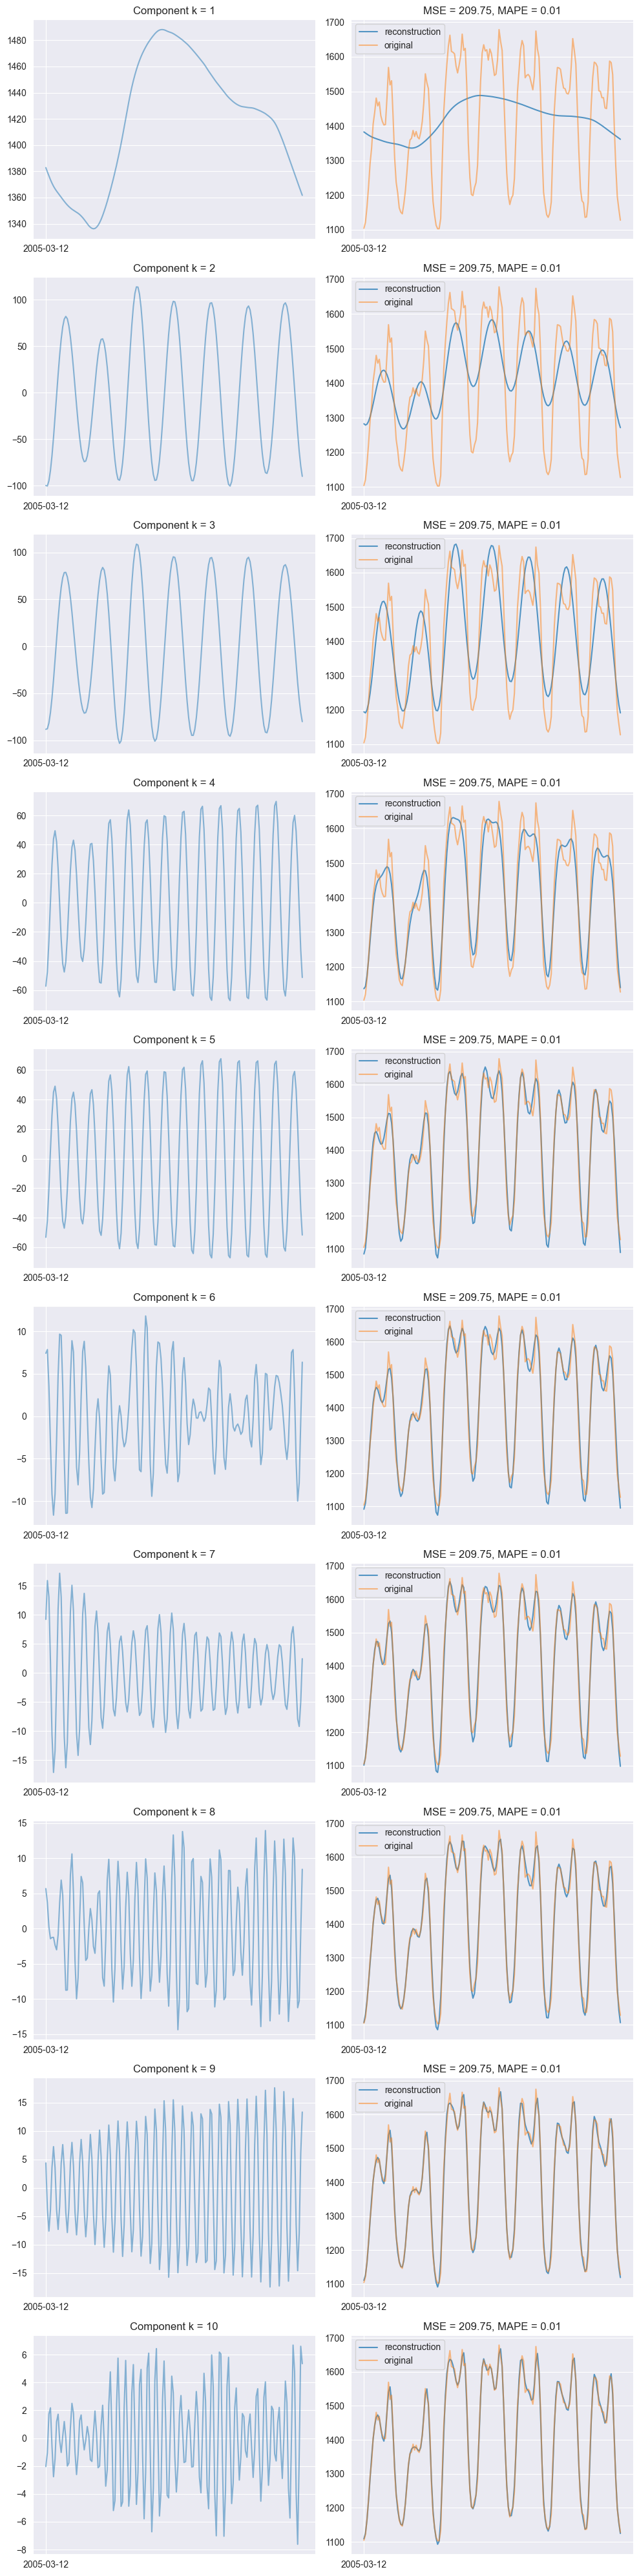

In [20]:
window_take = 10
week_idx = 11

fig = plt.figure(figsize=(10, window_take * 4))
for k in range(0, window_take):
    plt.subplot(window_take, 2, 2 * k + 1)

    week_x = lambda data : take_week(data, week_idx)

    kth_component = ssa_x[k]
    plt.plot(week_x(t), week_x(kth_component), label=f'k = {k+1}', alpha=0.5)
    plt.xticks([week_x(t)[0]])
    plt.title(f'Component k = {k+1}')

# ============================================================s

    plt.subplot(window_take, 2, 2 * k + 2)

    first_k_sum = np.sum(ssa_x[:k+1], axis=0)
    plt.plot(week_x(t), week_x(first_k_sum), label=f'reconstruction', alpha=0.75)
    plt.plot(week_x(t), week_x(x), label='original', alpha=0.5)
    # take only first tick
    plt.xticks([week_x(t)[0]])
    plt.legend()

    plt.title(f'MSE = {mse:.2f}, MAPE = {mape:.2f}')

plt.tight_layout()
plt.show()

Сумма до первых 10 компонент за недели 11, 21, 31; смысловая группировка компонент

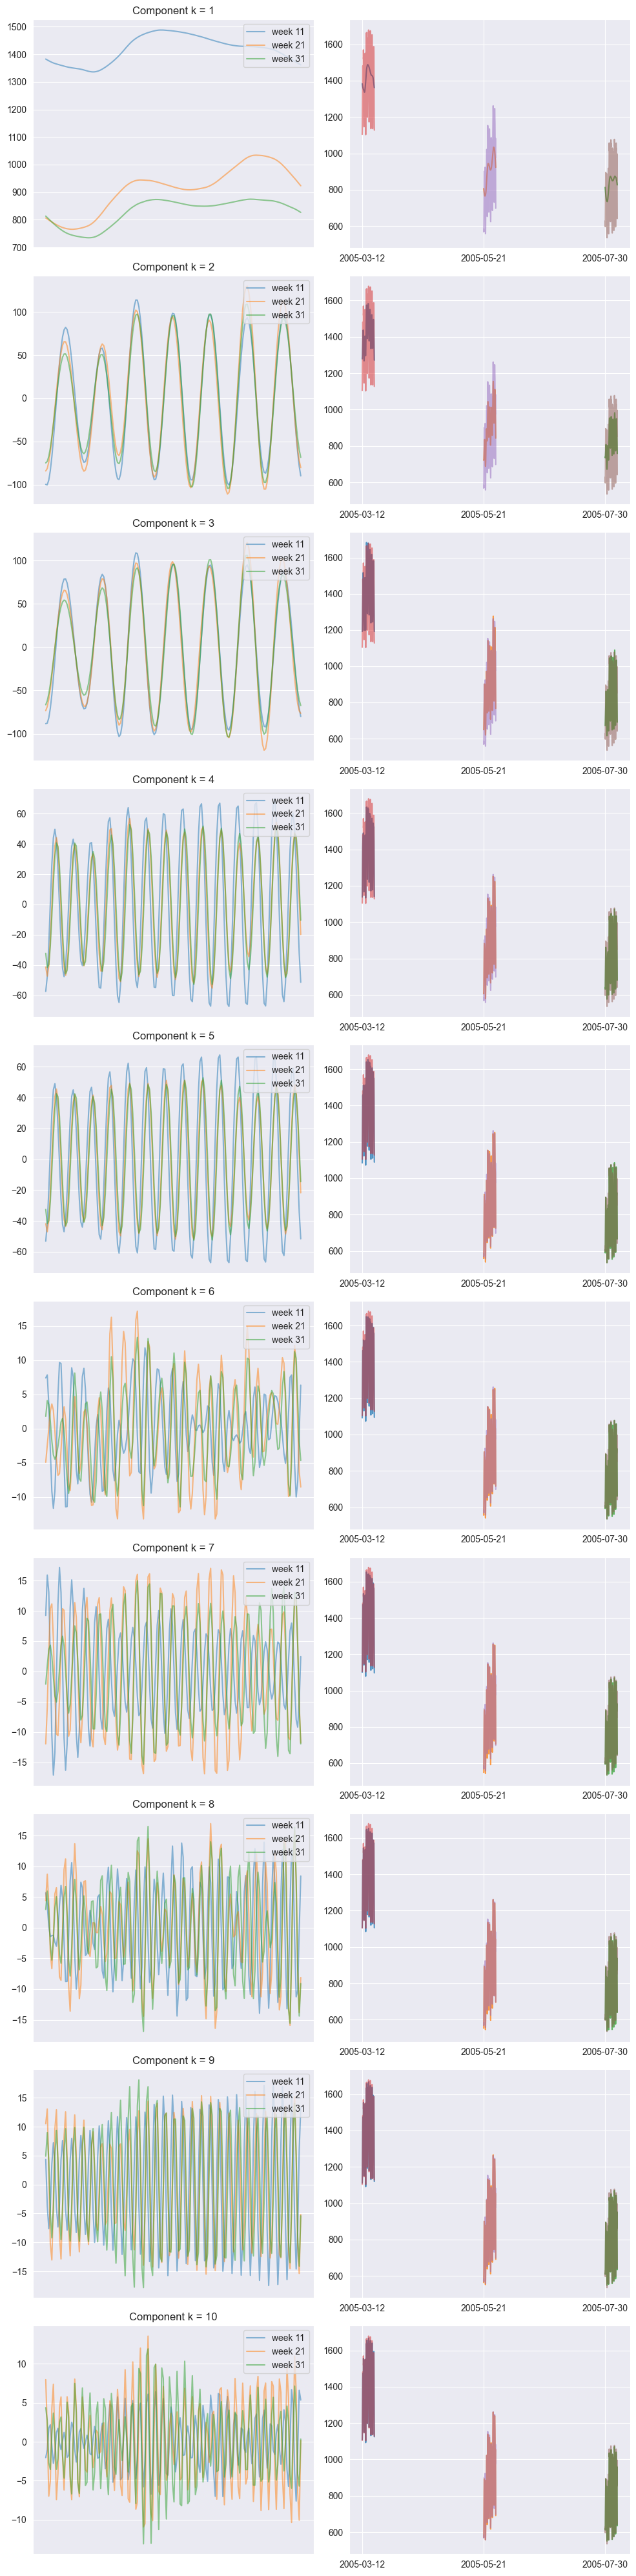

In [21]:
window_take = 10
week_idx = 11

fig = plt.figure(figsize=(10, window_take * 4))
for k in range(0, window_take):
    plt.subplot(window_take, 2, 2 * k + 1)

    week_x = lambda data : take_week(data, week_idx)
    week_xx = lambda data : take_week(data, week_idx+10)
    week_xxx = lambda data : take_week(data, week_idx+20)

    kth_component = ssa_x[k]
    plt.plot(week_x(t), week_x(kth_component), label=f'week 11', alpha=0.5)
    plt.plot(week_x(t), week_xx(kth_component), label=f'week 21', alpha=0.5)
    plt.plot(week_x(t), week_xxx(kth_component), label=f'week 31', alpha=0.5)
    plt.xticks([])
    plt.legend(loc='upper right')
    plt.title(f'Component k = {k+1}')

# ============================================================s

    plt.subplot(window_take, 2, 2 * k + 2)

    first_k_sum = np.sum(ssa_x[:k+1], axis=0)
    plt.plot(week_x(t), week_x(first_k_sum), label=f'reconstruction', alpha=0.75)
    plt.plot(week_xx(t), week_xx(first_k_sum), label=f'reconstruction', alpha=0.75)
    plt.plot(week_xxx(t), week_xxx(first_k_sum), label=f'reconstruction', alpha=0.75)
    plt.plot(week_x(t), week_x(x), label='original', alpha=0.5)
    plt.plot(week_xx(t), week_xx(x), label='original', alpha=0.5)
    plt.plot(week_xxx(t), week_xxx(x), label='original', alpha=0.5)
    # take only first tick
    plt.xticks([week_x(t)[0], week_xx(t)[0], week_xxx(t)[0]])
    # plt.legend()

plt.tight_layout()
plt.show()

Видно, что компоненты 2-5 складываются в группу, которая дает общую форму недельной сезонности. В разное время года они обладают разными амплитудами, но период четко выражен.

Компоненты 6-9 так же обьединяются в логическую группу, но уже имеют чуть сдвинутые периоды. Дальнейшие частоты тоньше подстраивают значения к локально необходимым величинам

Графики ошибки от компоненты восстановления

In [22]:
metrics_ssa = {
    'MSE': [],
    'MAPE': []
}

for k in range(0, window_width):
    first_k_sum = np.sum(ssa_x[:k+1], axis=0)

    mse = MSE(x, first_k_sum)
    mape = MAPE(x, first_k_sum)

    metrics_ssa['MSE'].append(mse)
    metrics_ssa['MAPE'].append(mape)

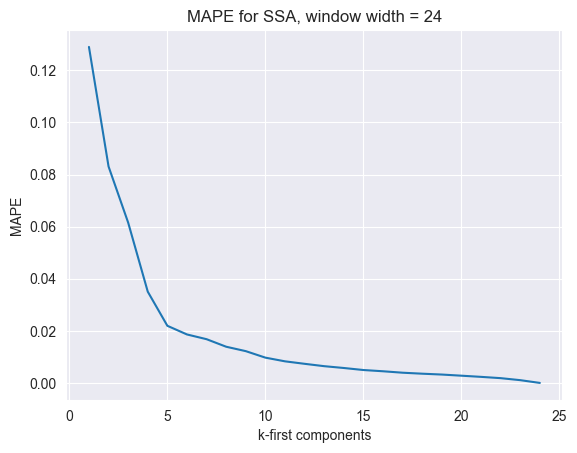

In [24]:
sns.lineplot(x=np.arange(1, window_width + 1), y=metrics_ssa['MAPE'])
plt.ylabel('MAPE')
plt.xlabel('k-first components')
plt.title('MAPE for SSA, window width = 24')
plt.show()

In [25]:
def hankel(x, window_size):
    return np.array([x[i:i+window_size] for i in range(0, len(x) - window_size + 1)])

def unhankel(x):
    dims_left = list(x.shape[2:])
    shape = [x.shape[0] + x.shape[1] - 1] + dims_left

    sums = np.zeros(shape)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            sums[i+j] += x[i,j]

    for i in range(len(sums)):
        d = min([i + 1, x.shape[0], x.shape[1], len(sums) - i])
        sums[i] /= d

    return sums

In [26]:
window_width = hankelization_window_width

hankel_x = hankel(hankel(x, window_width), window_width)
hankel_x.shape

(8714, 24, 24)

In [27]:
parafac_rank = parafac_rank
parafac_x = tl.decomposition.parafac(
    hankel_x,
    rank=parafac_rank,

    n_iter_max=100,
    tol=1e-6,

    verbose=False
)

In [28]:
metricts_parafac = {
    'MSE': [],
    'MAPE': []
}

for i in range(1, parafac_rank):
    weights = np.zeros(parafac_rank)
    weights[:i] = 1
    parafac_x.weights = weights

    px = tl.cp_to_tensor(parafac_x)
    restored_x = unhankel(unhankel(px))

    mse = MSE(x, restored_x)
    mape = MAPE(x, restored_x)

    metricts_parafac['MSE'].append(mse)
    metricts_parafac['MAPE'].append(mape)

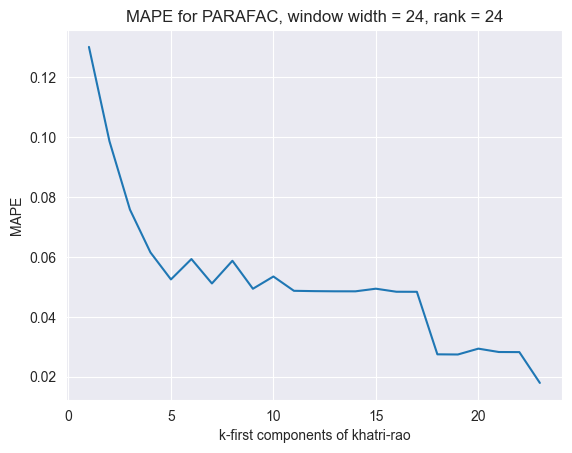

In [31]:
sns.lineplot(x=np.arange(1, parafac_rank), y=metricts_parafac['MAPE'])
plt.ylabel('MAPE')
plt.xlabel('k-first components of khatri-rao')
plt.title('MAPE for PARAFAC, window width = 24, rank = 24')
plt.show()

Сравним полученные графики

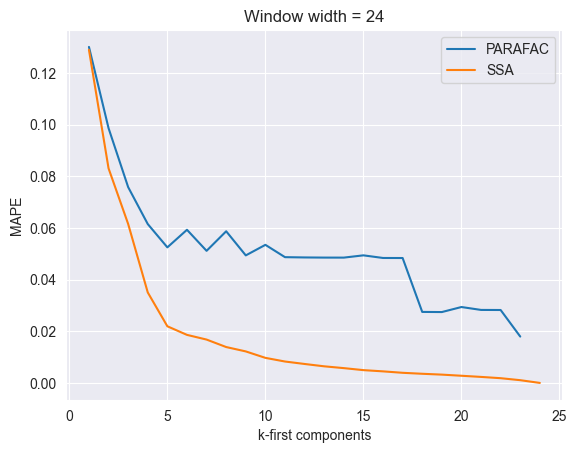

In [39]:
sns.lineplot(x=np.arange(1, parafac_rank), y=metricts_parafac['MAPE'], label='PARAFAC')
sns.lineplot(x=np.arange(1, window_width + 1), y=metrics_ssa['MAPE'], label='SSA')
plt.ylabel('MAPE')
plt.xlabel('k-first components')
plt.title('Window width = 24')
plt.show()

In [40]:
x.shape

(8760,)